In [1]:
%load_ext lab_black

from scipy.interpolate import CubicSpline
from scipy import stats
import numpy as np
import admix
import pandas as pd
import itertools
import os
import glob
from tqdm import tqdm
import admix_genet_cor
import matplotlib.pyplot as plt

In [128]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
ROOT_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr"
)
PFILE_DIR = os.path.join(ROOT_DIR, "imputed")
trait_list = [
    f.split("/")[-1].split(".")[0]
    for f in glob.glob(os.path.join("out/pheno", "*.tsv"))
]

trait_list = [t for t in trait_list if "duffy" in t]

In [107]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["hm3", "imputed"],
            ["mafukb", "gcta"],
            [0.005, 0.05],
        )
    ],
    columns=[
        "snpset",
        "hermodel",
        "maf",
    ],
)

df_params["grm_prefix"] = df_params.apply(
    lambda p: f"{p.snpset}.{p.hermodel}.{str(p.maf)[2:]}",
    axis=1,
)
df_params = pd.DataFrame(
    #     [params for params in itertools.product(df_params.grm_prefix, trait_list)],
    [params for params in itertools.product(["imputed.mafukb.005"], trait_list)],
    columns=["grm_prefix", "trait"],
)

In [108]:
dict_loglik = {trait: dict() for trait in trait_list}
rho_list = np.linspace(0, 1, 21)
xs = np.linspace(0, 1, 1001)

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
    trait, grm_prefix = param.trait, param.grm_prefix
    est_dir = f"out-newPC/gcta-estimate/{trait}-{grm_prefix}"
    try:
        loglik_list = [
            admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho{int(rho * 100)}"))[
                "loglik"
            ]
            for rho in rho_list
        ]
        cs = CubicSpline(rho_list, loglik_list)
        ll = cs(xs)
        dict_loglik[trait][grm_prefix] = ll
    except ValueError as err:
        print(param.trait, err)

 88%|████████▊ | 21/24 [00:02<00:00,  9.85it/s]

hypertension can only convert an array of size 1 to a Python scalar


100%|██████████| 24/24 [00:02<00:00,  9.31it/s]


In [109]:
for grm_prefix in df_params.grm_prefix.unique():
    meta_ll = 0
    for trait in trait_list:
        if trait != "hypertension":
            meta_ll += dict_loglik[trait][grm_prefix]
    print(grm_prefix, meta_ll.argmax() / 1000, admix_genet_cor.hdi(xs, meta_ll))

imputed.mafukb.005 0.728 (0.652, 0.793)


In [112]:
trait

'hypertension'

In [121]:
df_plot = {"trait": [], "grm_prefix": [], "mode": [], "lower": [], "upper": []}

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):

    trait, grm_prefix = param.trait, param.grm_prefix

    if trait == "hypertension":
        continue
    mode = dict_loglik[trait][grm_prefix].argmax() / 1000
    interval = admix_genet_cor.hdi(xs, dict_loglik[trait][grm_prefix])
    df_plot["trait"].append(trait)
    df_plot["grm_prefix"].append(grm_prefix)
    df_plot["mode"].append(mode)
    if isinstance(interval, list):
        print(f"{trait}, {grm_prefix} has more than 1 interval, making them nan")
        interval = [np.nan, np.nan]
    df_plot["lower"].append(interval[0])
    df_plot["upper"].append(interval[1])
df_plot = pd.DataFrame(df_plot)
df_plot["length"] = df_plot["upper"] - df_plot["lower"]

100%|██████████| 24/24 [00:00<00:00, 807.93it/s]


In [122]:
df_plot_old = pd.read_csv("results/all-duffy-covar.tsv", sep="\t")

In [123]:
df_plot_old2 = pd.read_csv("../03-page-genome-wide/results/all-estimates.tsv", sep="\t")

In [124]:
df_tmp = df_plot_old2[
    (df_plot_old2.hermodel == "mafukb")
    & (df_plot_old2.trait.isin([t[:-6] for t in trait_list]))
    & (df_plot_old2.duffy_covar == True)
].set_index("trait")

In [125]:
df_tmp2 = df_plot_old[df_plot_old.grm_prefix == "imputed.mafukb.005"].set_index("trait")

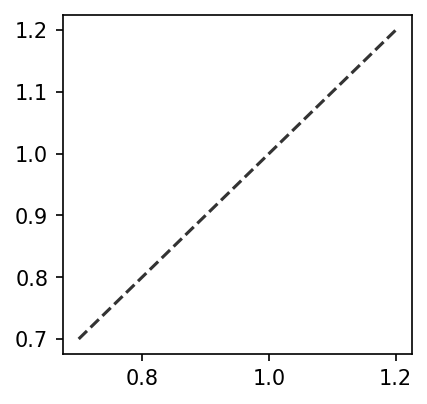

In [126]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_tmp.rg, df_tmp2["mode"].reindex(df_tmp.index))
ax.plot([0.7, 1.2], [0.7, 1.2], "k--", alpha=0.8)

Text(0, 0.5, 'Old')

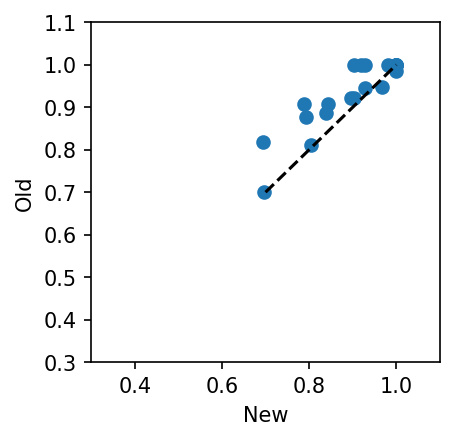

In [127]:
df_merged = pd.merge(df_plot, df_plot_old, on=["trait", "grm_prefix"])
df_merged = df_merged[df_merged.grm_prefix == "imputed.mafukb.005"]
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_merged["mode_x"], df_merged["mode_y"])
ax.plot([0.7, 1.0], [0.7, 1.0], ls="--", color="k")
ax.set_xlim(0.3, 1.1)
ax.set_ylim(0.3, 1.1)
ax.set_xlabel("New")
ax.set_ylabel("Old")

# Compare new PC and old PC

In [129]:
trait_list = [
    f.split("/")[-1].split(".")[0]
    for f in glob.glob(os.path.join("out/pheno", "*.tsv"))
]

trait_list = [t for t in trait_list if not "duffy" in t]

In [136]:
dict_loglik1 = {}
rho_list = np.linspace(0, 1, 21)
xs = np.linspace(0, 1, 1001)

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
    trait, grm_prefix = param.trait, param.grm_prefix
    est_dir = f"out-newPC/gcta-estimate/{trait}-{grm_prefix}"
    try:
        loglik_list = [
            admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho{int(rho * 100)}"))[
                "loglik"
            ]
            for rho in rho_list
        ]
        cs = CubicSpline(rho_list, loglik_list)
        ll = cs(xs)
        dict_loglik1[trait] = ll
    except ValueError as err:
        print(param.trait, err)

 88%|████████▊ | 21/24 [00:02<00:00,  9.67it/s]

hypertension can only convert an array of size 1 to a Python scalar


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


In [137]:
dict_loglik2 = {}
rho_list = np.linspace(0, 1, 21)
xs = np.linspace(0, 1, 1001)

for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
    trait, grm_prefix = param.trait, param.grm_prefix
    est_dir = f"out/gcta-estimate/{trait}-{grm_prefix}"
    try:
        loglik_list = [
            admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho{int(rho * 100)}"))[
                "loglik"
            ]
            for rho in rho_list
        ]
        cs = CubicSpline(rho_list, loglik_list)
        ll = cs(xs)
        dict_loglik2[trait] = ll
    except ValueError as err:
        print(param.trait, err)

100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


In [148]:
est = []
for trait in trait_list:
    if (trait in dict_loglik1) and (trait in dict_loglik2):
        mode1 = dict_loglik1[trait].argmax() / 1000
        mode2 = dict_loglik2[trait].argmax() / 1000
        est.append([trait, mode1, mode2])
df_est = pd.DataFrame(est)

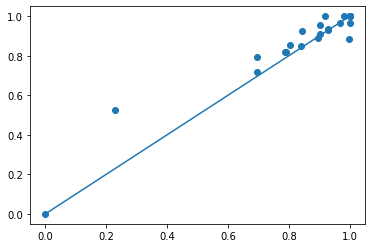

In [147]:
plt.scatter(df_est[1], df_est[2])
plt.plot([0, 1], [0, 1])